# 인공지능적사고와문제해결 프로젝트2 8조

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import lightgbm

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE


In [14]:
# set options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [15]:
# 예측한 값으로 성능을 평가하는 함수
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred) # 오차 행렬
    accuracy = accuracy_score(y_test, pred) # 정확도
    precision = precision_score(y_test, pred) # 정밀도
    recall = recall_score(y_test, pred) # 재현율
    f1 = f1_score(y_test, pred) # F1
    roc_auc = roc_auc_score(y_test, pred_proba) # ROC-AUC
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

## 데이터 전처리

In [16]:
vote_df = pd.read_csv("train.csv", encoding="utf-8")
test_df = pd.read_csv("test.csv", encoding="utf-8")
print("dataset shape: ", vote_df.shape)
print("dataset shape: ", test_df.shape)

# 인덱스 제거
vote_df.drop("index", axis=1, inplace=True)
test_index = test_df["index"]
test_df.drop("index", axis=1, inplace=True)

dataset shape:  (36425, 78)
dataset shape:  (9107, 77)


In [17]:
# 0값을 검사할 피처명 리스트 객체 설정
# zero_features = ['education', 'engnat', 'hand', 'urban']
# education 비율 맞추기?
zero_features = []

# tp 추가
for i in range(1, 11):
    s = 'tp' + chr(48+(i//10)) + chr(48+(i%10))
    zero_features.append(s)
    
# zero_features 리스트 내부에 저장된 개별 피처들에 대해 0값을 평균 값으로 대체
vote_df[zero_features] = vote_df[zero_features].replace(0, vote_df[zero_features].mean())
test_df[zero_features] = test_df[zero_features].replace(0, test_df[zero_features].mean())

### 인코딩

In [18]:
# 레이블 인코딩
encoder = LabelEncoder()
encoder_test = LabelEncoder()

encoder.fit(vote_df['age_group'])
encoder_test.fit(test_df['age_group'])
labels = encoder.transform(vote_df['age_group'])
labels_test = encoder_test.transform(test_df['age_group'])

vote_df['age_group'] = labels
test_df['age_group'] = labels_test

def get_categoty_age(age_num):
    num = age_num;
    if age_num == 0: num =7

    return num

vote_df["age_group"] = vote_df["age_group"].apply(lambda x : get_categoty_age(x))
test_df["age_group"] = test_df["age_group"].apply(lambda x : get_categoty_age(x))

# 원핫 인코딩
def dummy_data(data, columns) :
    for column in columns:
        data = pd.concat([data, pd.get_dummies(data[column], prefix = column)], axis=1)
        data = data.drop(column, axis=1)
    return data

dummy_columns = ['engnat', 'gender','hand', 'married', 'race', 'religion', 'urban']
# wr 추가
for i in range(1, 14):
    s = 'wr_' + chr(48+(i//10)) + chr(48+(i%10))
    dummy_columns.append(s)
# wf 추가
for i in range(1, 4):
    s = 'wf_' + chr(48+(i//10)) + chr(48+(i%10))
    dummy_columns.append(s)
# print(dummy_columns)

vote_df = dummy_data(vote_df, dummy_columns)
test_df = dummy_data(test_df, dummy_columns)


### 이상값 처리

In [19]:
# 시간 데이터 전처리

#Q_E 시간
Q_E = []
for i in range(97, 117):
    a = 'Q' + chr(i) + 'E'
    Q_E.append(a)

def get_categoty_time(Q_time):
    cat = 0
    if Q_time <= 1000 : cat = 1
    elif Q_time <= 2000 : cat = 2
    elif Q_time <= 3000 : cat = 3
    elif Q_time <= 4000 : cat = 4
    elif Q_time <= 5000 : cat = 5
    elif Q_time <= 6000 : cat = 6
    elif Q_time <= 7000 : cat = 7
    elif Q_time <= 8000 : cat = 8
    elif Q_time <= 9000 : cat = 9
    elif Q_time <=10000 : cat = 10
    elif Q_time <=15000 : cat = 11
    elif Q_time <=20000 : cat = 12
    else : Q_time = 13

    return cat

for Q_time in Q_E:
    vote_df[Q_time] = vote_df[Q_time].apply(lambda x : get_categoty_time(x))
    test_df[Q_time] = test_df[Q_time].apply(lambda x : get_categoty_time(x))


In [20]:
# 이상치 데이터 제거
def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[df['voted']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight    
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index    
    return outlier_index

# train data: race_White, religion_Agnostic  religion_Atheist  
outlier_index = get_outlier(df=vote_df, column="race_White", weight=1.5)
vote_df.drop(outlier_index, axis=0, inplace=True)

outlier_index = get_outlier(df=vote_df, column="religion_Agnostic", weight=1.5)
vote_df.drop(outlier_index, axis=0, inplace=True)

outlier_index = get_outlier(df=vote_df, column="religion_Atheist", weight=1.5)
vote_df.drop(outlier_index, axis=0, inplace=True)

## 모델 학습

In [24]:
# label/feature 분리 및 학습세트/평가세트 분리
y_labels = vote_df.loc[:,'voted']
X_features = vote_df.drop('voted', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=156)

# 분포 비율 확인
train_cnt = y_train.count()
test_cnt = y_test.count()

print("학습 세트 Shape:{0}, 테스트 세트 Shape:{1}".format(X_train.shape, X_test.shape))
print(" 학습 세트 레이블 값 분포 비율")
print(y_train.value_counts()/train_cnt)
print("\n 테스트 세트 레이블 값 분포 비율")
print(y_test.value_counts()/test_cnt)
print()

# 데이터 정규화(스케일링)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

test_sc = scaler.transform(test_df) # test data scaling

# oversampling
#over_sampler = RandomOverSampler(random_state=156)
#X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
import imblearn
from imblearn.under_sampling import RandomUnderSampler
#undersampling
under_sampler = RandomUnderSampler(random_state=156)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)


# # smote oversampling
# smote = SMOTE(random_state=156)
# X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

# 학습
evals = [(X_test, y_test)]
xgb_model = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3, objective="binary:logistic", random_state=156)
xgb_model.fit(X_train_under, y_train_under, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=True)
preds = xgb_model.predict(X_test)
pred_proba = xgb_model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, preds, pred_proba)

학습 세트 Shape:(23740, 121), 테스트 세트 Shape:(5935, 121)
 학습 세트 레이블 값 분포 비율
0    0.669966
1    0.330034
Name: voted, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.676158
1    0.323842
Name: voted, dtype: float64

[0]	validation_0-logloss:0.647435
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.611237
[2]	validation_0-logloss:0.581643
[3]	validation_0-logloss:0.557175
[4]	validation_0-logloss:0.536819
[5]	validation_0-logloss:0.519897
[6]	validation_0-logloss:0.505154
[7]	validation_0-logloss:0.492855
[8]	validation_0-logloss:0.481236
[9]	validation_0-logloss:0.472138
[10]	validation_0-logloss:0.463364
[11]	validation_0-logloss:0.456179
[12]	validation_0-logloss:0.450138
[13]	validation_0-logloss:0.444111
[14]	validation_0-logloss:0.43925
[15]	validation_0-logloss:0.435058
[16]	validation_0-logloss:0.431256
[17]	validation_0-logloss:0.428045
[18]	validation_0-logloss:0.425211
[19]	validation_0-logloss:0.422134
[20]	validation_0-logloss:0.419866
[21

# K-fold

In [27]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

result_skfold = StratifiedKFold(n_splits=5)
idx_iter=0
cv_accuracy =[]

for train_index, test_index in result_skfold.split(X_features, y_labels):
    X_train_under, X_test = X_features[train_index], X_features[test_index]
    y_train_under, y_test = y_labels[train_index], y_labels[test_index]
    
    result_clf.fit(X_train_under, y_train_under)
    pred = result_clf(X_test)
    
    idx_iter += 1
    accuracy = np.round(accuracy_score(y_test, pred),4 )
    train_size = X_train_under.shape[0]
    test_size = X_test.shape[0]
    
    cv_accuracy.append(accuracy)

KeyError: "None of [Int64Index([ 5852,  5854,  5857,  5858,  5859,  5861,  5862,  5866,  5873,\n             5874,\n            ...\n            29665, 29666, 29667, 29668, 29669, 29670, 29671, 29672, 29673,\n            29674],\n           dtype='int64', length=23740)] are in the [columns]"

In [ ]:
#스태킹앙상블
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

def get_stacking_nase_datasets(model, X_train_n, y_train_n, X_test_n, n_folds) :
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=156)
    
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        medel.fit(X_tr, y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        test_pred[:, folder_counter] = model.predict(X_test_n)
        
    test_pred_mean == np.mean(test_pred, axis=1).reshape(-1, 1)
    
    return train_fold_pred, test_pred_mean



knn_train, knn_test = get_stacking_base_datasets(xgb_model, X_train_under, y_train_under, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)


Stack_final_X_train = np.concatenate((knn_train))

### 테스트 데이터 예측

In [10]:
xgb_model_test = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3, objective="binary:logistic", random_state=156)
xgb_model_test.fit(X_features.sample(test_df.shape[0]), y_labels.sample(test_df.shape[0]), eval_metric="logloss")

# preds_test = xgb_model.predict(test_df)
# pred_proba_test = xgb_model.predict_proba(test_df)[:,1]
preds_test = xgb_model.predict(test_sc)
pred_proba_test = xgb_model.predict_proba(test_sc)[:,1]

test_submission = pd.DataFrame({"index" : test_index,
                                "pred_prob" : pred_proba_test,
                                "pred" : preds_test})

In [11]:
test_submission.head(10)

,index,pred_prob,pred
0,38741,0.000649,0
1,43904,0.832067,1
2,41036,0.000603,0
3,6939,0.500074,1
4,14682,0.000682,0
5,35469,0.000390,0
6,33948,0.000598,0
7,3082,0.026799,0
8,33291,0.826314,1
9,32694,0.723136,1


### feature selection

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

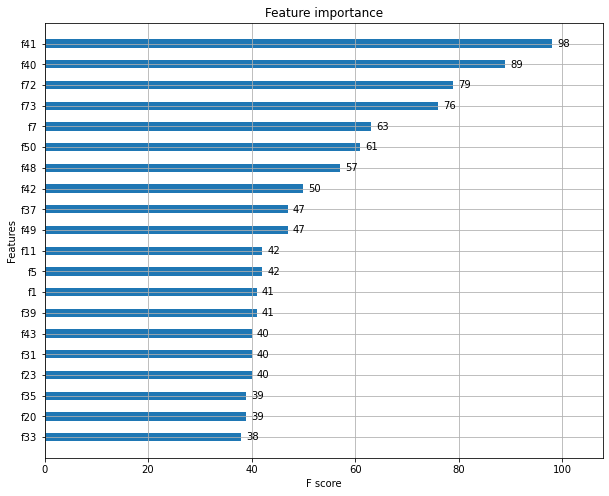

In [14]:
from xgboost import plot_importance
fig, ax = plt.subplots(1,1, figsize=(10,8))
plot_importance(xgb_model, ax=ax, max_num_features=20, height=0.4)